In [ ]:
import os
import gc
import logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow as tf
import innvestigate
# This is required for innvestigate and must be called before models are loaded.
tf.compat.v1.disable_eager_execution()
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from keras import regularizers
from keras.models import Model
from keras.layers import Dense,LeakyReLU, Dropout, Add, Activation
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import plot_model
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import Callback
from matplotlib.colors import Normalize
from sklearn.preprocessing import FunctionTransformer
tf.keras.utils.set_random_seed(0)
tf.config.list_physical_devices('GPU')
tf.compat.v1.disable_eager_execution()
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.engine.training_v1")
import xarray as xr
#import innvestigate
import scipy.io as sio
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.signal import butter, sosfilt
from tensorflow.keras.models import load_model

2025-07-03 15:09:40.209967: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-03 15:09:41.545908: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-03 15:09:41.822437: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
In_name = "TS_anom" #
Out_name = "TOA_anom" #



######### CESM1 #########
file_hist = "/ocean/projects/ees250004p/ezhu3/data/CESM1/test/test.historical.ens-mean.ANN.1920-2100.new.nc"
# file_2xCO2 = "/ocean/projects/ees240007p/hwei1/Yue/test/test.2xCO2.ANN.new.nc"
file_4xCO2 = "/ocean/projects/ees250004p/ezhu3/data/CESM1/test/test.4xCO2.ANN.new.nc"
######### CESM1 #########


'''
######### CESM2 #########
file_hist = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-historical.ens-mean.ANN.1850-2014.nc"
# file_2xCO2 = "/ocean/projects/ees240007p/hwei1/Yue/test/test.2xCO2.ANN.new.nc"
file_4xCO2 = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-4xCO2.ANN.nc"
######### CESM2 #########
'''
# === Load historical data ===
ds_hist = xr.open_dataset(file_hist)
print("Historical dataset loaded:", ds_hist)

Historical dataset loaded: <xarray.Dataset>
Dimensions:   (lon: 288, lat: 192, time: 181)
Coordinates:
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * time      (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099 2100
Data variables:
    TS        (time, lat, lon) float32 ...
    TOA       (time) float64 ...
    TOA_anom  (time) float64 ...
    TS_anom   (time, lat, lon) float32 ...
Attributes:
    ERF:      ERF = F - F_ctrl; my old CAM5 forcing run at /glade/campaign/un...
    script:   /glade/work/dongy24/Python/create_input_for_huaiyu.ipynb
    author:   Y. Dong, 03/23/2025


In [3]:
lat = ds_hist["lat"]
lon = ds_hist["lon"]

time_hist = ds_hist["time"] 

######### CESM2 #########
#time_hist = [date.year for date in time_hist.values] #for C2 data
######### CESM2 #########

######### CESM1 #########
time_hist = time_hist.values #for C1 data
######### CESM1 #########

TS_hist = ds_hist[In_name]
TOA_hist = ds_hist[Out_name].values

# === Load 2xCO2 data ===
# ds_2xCO2 = xr.open_dataset(file_2xCO2)
# print("2xCO2 dataset loaded:", ds_2xCO2)

# time_2xCO2 = ds_2xCO2["year"]
# TS_2xCO2 = ds_2xCO2[In_name]
# TOA_2xCO2 = ds_2xCO2[Out_name].values

# === Load 4xCO2 data ===
ds_4xCO2 = xr.open_dataset(file_4xCO2)
print("4xCO2 dataset loaded:", ds_4xCO2)


# time_4xCO2_coords = ds_4xCO2["year"]
# time_4xCO2 = time_4xCO2_coords.values

'''
######### CESM2 #########
time_4xCO2 = ds_4xCO2["time"] 
time_4xCO2 = [date.year for date in time_4xCO2.values] #for C2 data
######### CESM2 #########
'''
######### CESM1 #########
time_4xCO2 = ds_4xCO2["year"] 
time_4xCO2 = time_4xCO2.values #C1 data
######### CESM1 #########

TS_4xCO2 = ds_4xCO2[In_name]
TOA_4xCO2 = ds_4xCO2[Out_name].values

# Optional: Print shapes to verify
print("TS_hist shape:", TS_hist.shape)
# print("TS_2xCO2 shape:", TS_2xCO2.shape)
print("TS_4xCO2 shape:", TS_4xCO2.shape)

4xCO2 dataset loaded: <xarray.Dataset>
Dimensions:   (lat: 192, lon: 288, year: 150)
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * year      (year) int64 1850 1851 1852 1853 1854 ... 1995 1996 1997 1998 1999
Data variables:
    TS        (year, lat, lon) float64 ...
    TOA       (year) float64 ...
    TOA_anom  (year) float64 ...
    TS_anom   (year, lat, lon) float64 ...
Attributes:
    script:   /glade/work/dongy24/Python/create_input_for_huaiyu.ipynb
TS_hist shape: (181, 192, 288)
TS_4xCO2 shape: (150, 192, 288)


In [4]:
ds_hist[In_name][0,:,:]

<xarray.DataArray 'TS_anom' (lat: 192, lon: 288)>
[55296 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
    time     int64 1920
Attributes:
    units:    K
    note:     TS_anom = TS_his - TS_ref
    ref:      B1850C5CN mean state

In [5]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


--- Starting Comprehensive Out-of-Sample Evaluation ---
Loading normalization scalars from: /ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model_Gelu/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/TOA_anom/Normalization.mat

--- Testing all models against: CESM1_Historical ---
Loaded and normalized data from: /ocean/projects/ees250004p/ezhu3/data/CESM1/test/test.historical.ens-mean.ANN.1920-2100.new.nc


2025-07-03 15:09:51.649429: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-03 15:09:52.715081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0
2025-07-03 15:09:52.731800: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2025-07-03 15:09:54.509984: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2025-07-03 15:09:57.672932: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica

Finished evaluating all models for CESM1_Historical.


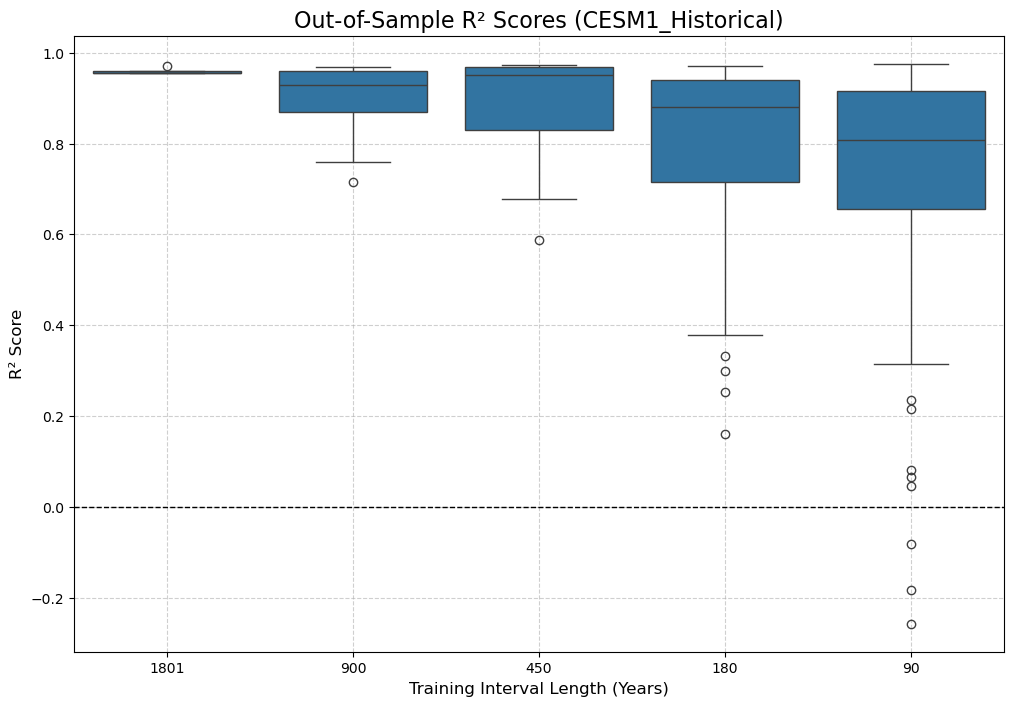


--- Testing all models against: CESM1_4xCO2 ---
Loaded and normalized data from: /ocean/projects/ees250004p/ezhu3/data/CESM1/test/test.4xCO2.ANN.new.nc


2025-07-03 15:12:43.605278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0
2025-07-03 15:12:44.411984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0
2025-07-03 15:12:45.212443: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0
2025-07-03 15:12:46.009467: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id

Finished evaluating all models for CESM1_4xCO2.


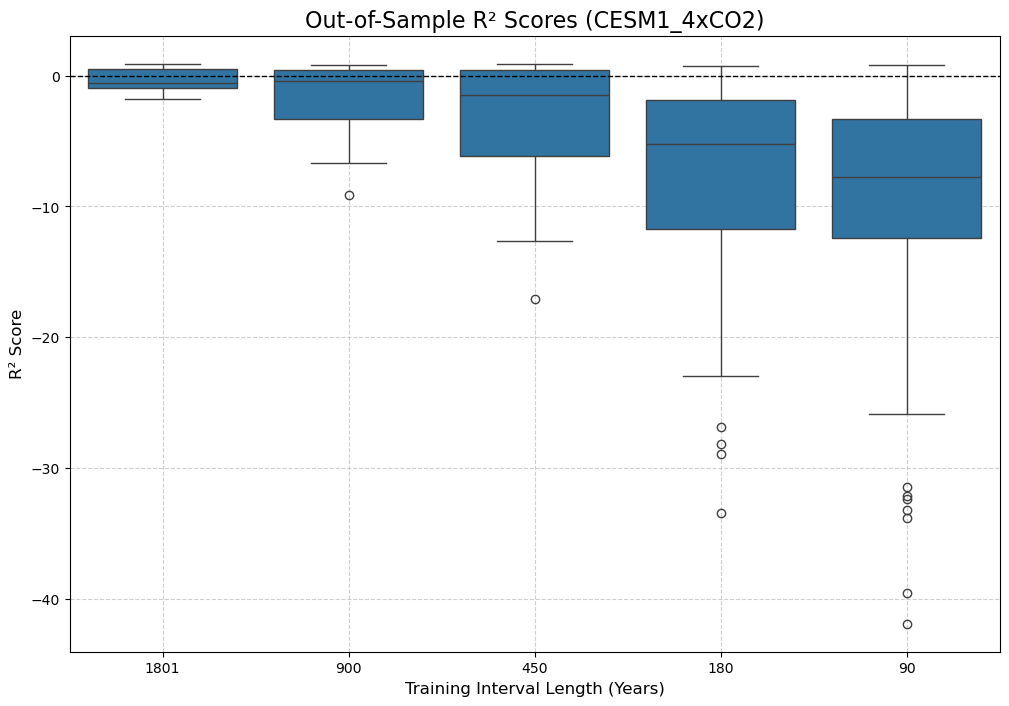


--- All Evaluation Scripts Finished ---


In [ ]:
#######################################################################
#                                                                     #
#               OUT-OF-SAMPLE PERFORMANCE EVALUATION                  #
#                                                                     #
#######################################################################

import os
import gc
import numpy as np
import tensorflow as tf
import xarray as xr
import scipy.io as sio
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score

print("--- Starting Comprehensive Out-of-Sample Evaluation ---")

# --- 1. Configuration ---
MODEL_DIR = "/ocean/projects/ees250004p/ezhu3/data/CESM1/trained_models_by_interval"
NORMALIZATION_FILE = "/ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model_Gelu/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/TOA_anom/Normalization.mat"

INTERVAL_DIVISIONS = [1, 2, 4, 10, 20]
TOTAL_YEARS = 1801
N_FOLDS = 5
N_ENSEMBLES = 1
IN_NAME = "TS_anom"
OUT_NAME = "TOA_anom"

# --- 2. Define All Out-of-Sample (OOS) Datasets to Test ---
# The script will loop through this dictionary and generate a separate
# boxplot for each entry.

# ### Use these paths for CESM1 ###
oos_datasets = {
    "CESM1_Historical": "/ocean/projects/ees250004p/ezhu3/data/CESM1/test/test.historical.ens-mean.ANN.1920-2100.new.nc",
    "CESM1_4xCO2": "/ocean/projects/ees250004p/ezhu3/data/CESM1/test/test.4xCO2.ANN.new.nc"
}

# ### OR: Use these paths for CESM2 (comment out the block above) ###
# oos_datasets = {
#     "CESM2_Historical": "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-historical.ens-mean.ANN.1850-2014.nc",
#     "CESM2_4xCO2": "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-4xCO2.ANN.nc"
# }


# --- 3. Load Normalization Scalars (once) ---
print(f"Loading normalization scalars from: {NORMALIZATION_FILE}")
norm_data = sio.loadmat(NORMALIZATION_FILE)
X_mean = norm_data['X_mean']
X_std = norm_data['X_std']
y_mean = norm_data['y_mean']
y_std = norm_data['y_std']


#######################################################################
#                                                                     #
#           MASTER EVALUATION & PLOTTING LOOP                         #
#                                                                     #
#######################################################################

# Loop through each OOS dataset defined above
for oos_name, oos_filepath in oos_datasets.items():
    print(f"\n======================================================================")
    print(f"--- Testing all models against: {oos_name} ---")
    print(f"======================================================================")

    # --- 4. Load and Prepare the current OOS dataset ---
    ds_oos = xr.open_dataset(oos_filepath)
    y_oos_raw = ds_oos[OUT_NAME].values.reshape(-1, 1)
    X_oos_raw = ds_oos[IN_NAME].values
    X_oos = X_oos_raw[..., np.newaxis]
    X_oos_normalized = (X_oos - X_mean) / X_std
    print(f"Loaded and normalized data from: {oos_filepath}")

    # --- 5. Inner Evaluation Loop ---
    evaluation_results = []
    for total_segments in INTERVAL_DIVISIONS:
        interval_duration_years = int(TOTAL_YEARS / total_segments)
        for segment_num in range(1, total_segments + 1):
            for fold_no in range(1, N_FOLDS + 1):
                for ens_no in range(1, N_ENSEMBLES + 1):
                    model_name = f"model_total_{total_segments}_segs_segment_{segment_num}_fold_{fold_no}_ens_{ens_no}.h5"
                    model_path = os.path.join(MODEL_DIR, model_name)
                    try:
                        tf.keras.backend.clear_session()
                        gc.collect()
                        model = load_model(model_path)
                        y_pred_normalized = model.predict(X_oos_normalized, verbose=0)
                        y_pred_unnormalized = (y_pred_normalized * y_std) + y_mean
                        r2 = r2_score(y_oos_raw, y_pred_unnormalized)
                        
                        evaluation_results.append({
                            'interval_years': interval_duration_years,
                            'r2_score': r2
                        })
                    except (IOError, OSError):
                        continue
    
    print(f"Finished evaluating all models for {oos_name}.")

    # --- 6. Generate Boxplot for the current OOS dataset ---
    if not evaluation_results:
        print(f"No results for {oos_name}, skipping plot.")
        continue

    results_df = pd.DataFrame(evaluation_results)
    sorted_intervals = sorted(results_df['interval_years'].unique(), reverse=True)

    plt.figure(figsize=(12, 8))
    sns.boxplot(x='interval_years', y='r2_score', data=results_df, order=sorted_intervals)
    plt.title(f'Out-of-Sample R² Scores ({oos_name})', fontsize=16)
    plt.xlabel('Training Interval Length (Years)', fontsize=12)
    plt.ylabel('R² Score', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axhline(0, color='k', linestyle='--', linewidth=1)
    if len(sorted_intervals) > 5:
        plt.xticks(rotation=45)
        
    plot_filename = f'summary_boxplot_r2_scores_{oos_name}.png'
    plt.savefig(os.path.join(MODEL_DIR, plot_filename), dpi=300, bbox_inches='tight')
    plt.show()

print("\n--- All Evaluation Scripts Finished ---")